In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

%load_ext autoreload
%autoreload 2

In [2]:
with open("data/pkl_files/prelim_inputs_0.pkl", "rb") as fp:
    prelim_inputs_0 = pickle.load(fp)
with open("data/pkl_files/prelim_inputs_1.pkl", "rb") as fp:
    prelim_inputs_1 = pickle.load(fp)
with open("data/pkl_files/prelim_outputs.pkl", "rb") as fp:
    outputs = pickle.load(fp)

In [3]:
inputs = np.concatenate((prelim_inputs_0, prelim_inputs_1), axis=0)

In [ ]:
"""
# This is a test to visualize our scans for our personal enjoyment
idx = np.random.randint(0,25650)
seg_img = outputs[idx,0,:,:]
plt.imshow(seg_img)
plt.show()
flair_img = inputs[idx,0,:,:]
plt.imshow(flair_img)
plt.show()
t1_img = inputs[idx,1,:,:]
plt.imshow(t1_img)
plt.show()
t1ce_img = inputs[idx,2,:,:]
plt.imshow(t1ce_img)
plt.show()
t2_img = inputs[idx,3,:,:]
plt.imshow(t2_img)
plt.show()
"""


In [4]:
#np.random.shuffle(inputs)
shuffled_idxs = list(range(inputs.shape[0]))
np.random.shuffle(shuffled_idxs)

train_cutoff = int(inputs.shape[0]*75/100)
val_cutoff = int(inputs.shape[0]*95/100)

train_data = []
val_data = []
test_data = []

for i, idx in enumerate(shuffled_idxs):
    if i < train_cutoff:
        train_data.append([inputs[idx], outputs[idx]])
    elif i < val_cutoff:
        val_data.append([inputs[idx], outputs[idx]])
    else:
        test_data.append([inputs[idx], outputs[idx]])
        
mean = np.mean(inputs[shuffled_idxs[:train_cutoff]], axis=0)

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=100)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=100)

print(len(train_loader))
print(len(train_data))

193
19237


In [6]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 30

print('using device:', device)

using device: cuda


In [8]:
model = None
optimizer = None 


mean_t = torch.tensor(mean).to(device=device, dtype=torch.float)
loss_arr = []
val_acc_arr = []
train_acc_arr = []

learning_rate = 1e-3

"""model = nn.Sequential(
    nn.Conv2d(4, 32, kernel_size=3, padding=1), 
    nn.ReLU(), 
    #nn.Conv2d(32, 32, kernel_size=3, padding=1), 
    #nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1), 
    nn.ReLU(), 
    #nn.Conv2d(64, 64, kernel_size=3, padding=1), 
    #nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1), 
    nn.ReLU(), 
    #nn.Conv2d(128, 128, kernel_size=3, padding=1), 
    #nn.ReLU(), 
    nn.ConvTranspose2d(128, 128, 2, stride=2),
    nn.Conv2d(128, 64, kernel_size=3, padding=1), 
    nn.ReLU(), 
    #nn.Conv2d(64, 64, kernel_size=3, padding=1), 
    #nn.ReLU(), 
    nn.ConvTranspose2d(64, 64, 2, stride=2),
    nn.Conv2d(64, 32, kernel_size=3, padding=1), 
    nn.ReLU(), 
    #nn.Conv2d(32, 32, kernel_size=3, padding=1), 
    #nn.ReLU(), 
    nn.Conv2d(32, 1, kernel_size=1) 
)"""
model = nn.Sequential(
    nn.Conv2d(4, 32, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(32, 32, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(64, 64, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(128, 128, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.ConvTranspose2d(128, 128, 2, stride=2),
    nn.Conv2d(128, 64, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(64, 64, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.ConvTranspose2d(64, 64, 2, stride=2),
    nn.Conv2d(64, 32, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(32, 32, kernel_size=3, padding=1), 
    nn.ReLU(), 
    nn.Conv2d(32, 1, kernel_size=1) 
)

if USE_GPU and torch.cuda.is_available():
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(params, lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)


In [ ]:
def iou_(outputs: torch.Tensor, labels: torch.Tensor):

    SMOOTH = 1e-6
    numpy_outputs = outputs.cpu().numpy()  
    numpy_labels = labels.cpu().numpy()
        
    intersection = np.logical_and(numpy_outputs, numpy_labels).sum((1, 2))
    # print("interection count: ", np.count_nonzero(intersection))

    union = np.logical_or(numpy_outputs, numpy_labels).sum((1, 2))
    # print("union count: ", np.count_nonzero(union))
    iou = (np.count_nonzero(intersection)+SMOOTH) / (np.count_nonzero(union)+SMOOTH)
    # print(iou)
    
    """idx = np.random.randint(1, 100)
    plt.imshow(numpy_outputs[idx,0,:,:])
    plt.show()
    plt.imshow(numpy_labels[idx,0])
    plt.show()"""
    
    return iou

In [ ]:
def test_iou():
    with torch.no_grad():
        for x,y in val_loader:
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.float)
            x -= mean_t
            scores = model(x)
            iou_(scores, y)
# test_iou()

In [9]:
############ FOR REFERENCE ############
def check_accuracy(loader, model, split):
    
    iou_total = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)
            x -= mean_t
            scores = model(x)
            # Will be using an Intersection over Union metric 
            iou_total += iou_(scores, y)
            num_samples += scores.shape[0]*scores.shape[1]
        acc = iou_total / num_samples
        if split == 'val':
            val_acc_arr.append(acc)
        else:
            train_acc_arr.append(acc)
        # print(type(iou_total))
        # print(num)
        print('Got %d / %d correct (%.2f)' % (iou_total, num_samples, 100 * acc))

In [10]:
# Got from https://gist.github.com/weiliu620/52d140b22685cf9552da4899e2160183#file-dice_coeff_loss-py-L2
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [11]:
def plot_output(scores, y):
    with torch.no_grad():
        numpy_scores = scores.cpu().numpy().astype(np.uint8)
        numpy_truth = y.cpu().numpy().astype(np.uint8)
        idx = np.random.randint(1, 100)
        plt.title('Segmented Output')
        plt.imshow(numpy_scores[idx,0,:,:])
        plt.show()
        plt.title('Ground Truth')
        plt.imshow(numpy_truth[idx,0,:,:])
        plt.show()

In [12]:
import torch.nn.functional as F

def train_model(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU

    for e in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)
            x -= mean_t
            scores = model(x)
            
            loss = dice_loss(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_arr.append(loss.item())
            
            if t % print_every == 0:
                print('Iteration %d of %d, loss = %.4f' % (t, len(train_loader), loss.item()))
                plot_output(scores, y)
                # check_accuracy(val_loader, model, 'val')
                # check_accuracy(train_loader, model, 'train')

Iteration 0 of 193, loss = 1.0928


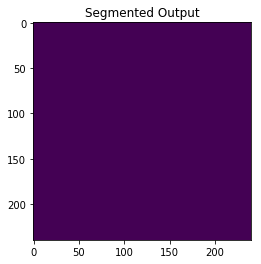

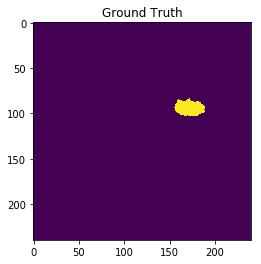

Iteration 30 of 193, loss = 0.9745


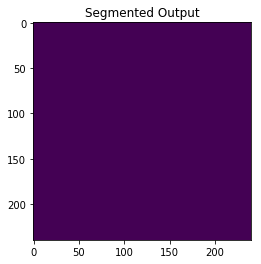

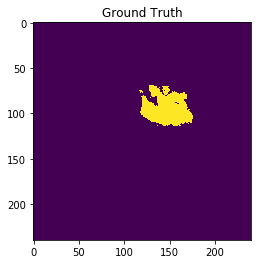

Iteration 60 of 193, loss = 0.8739


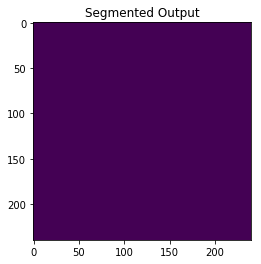

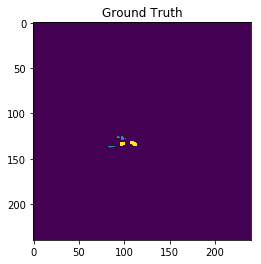

Iteration 90 of 193, loss = 0.8832


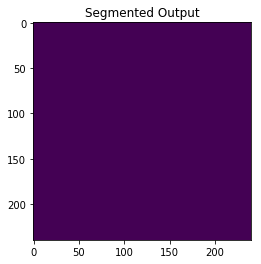

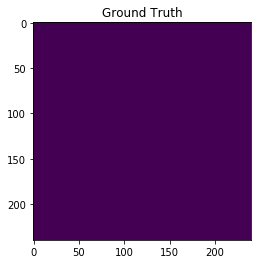

Iteration 120 of 193, loss = 0.8788


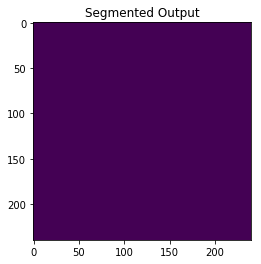

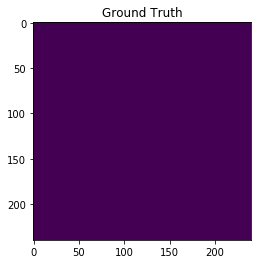

Iteration 150 of 193, loss = 0.8811


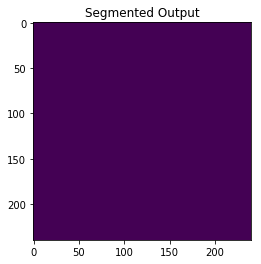

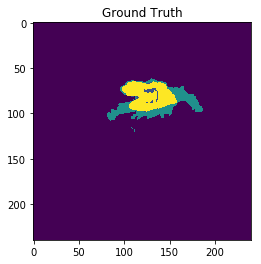

Iteration 180 of 193, loss = 0.8710


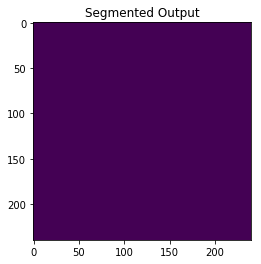

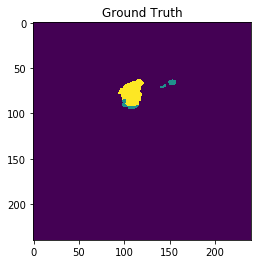

Iteration 0 of 193, loss = 0.8744


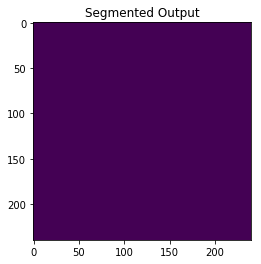

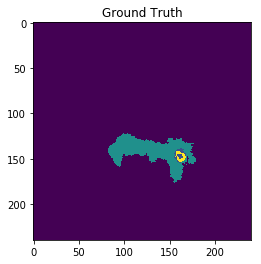

Iteration 30 of 193, loss = 0.8747


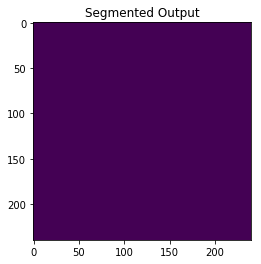

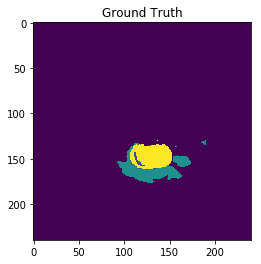

Iteration 60 of 193, loss = 0.8690


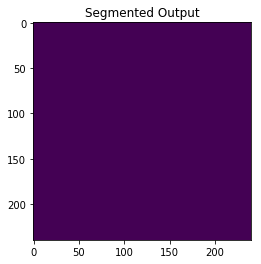

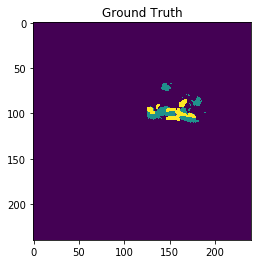

Iteration 90 of 193, loss = 0.8690


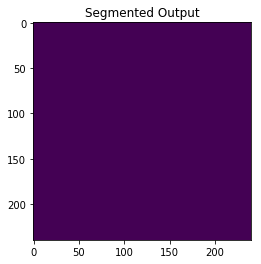

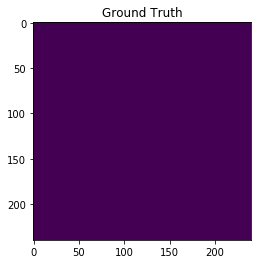

Iteration 120 of 193, loss = 0.8792


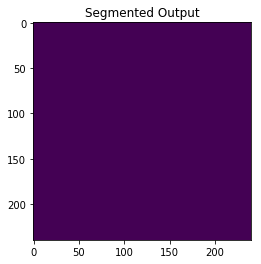

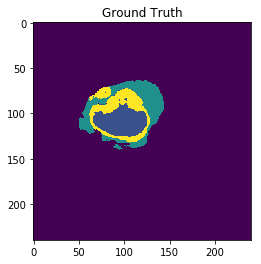

Iteration 150 of 193, loss = 0.8867


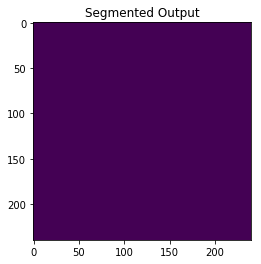

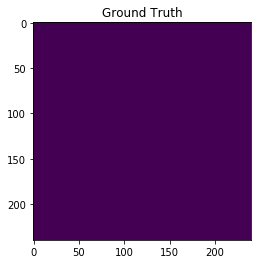

Iteration 180 of 193, loss = 0.8721


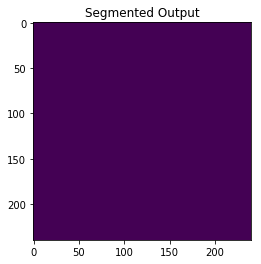

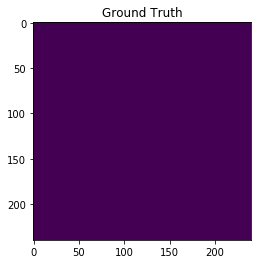

Iteration 0 of 193, loss = 0.8704


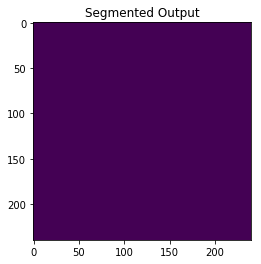

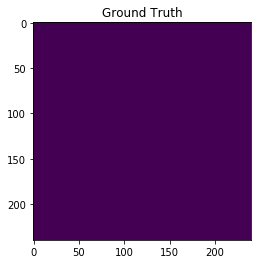

Iteration 30 of 193, loss = 0.8655


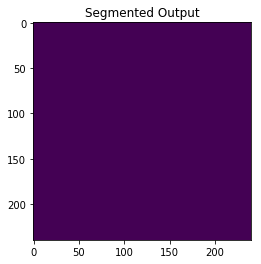

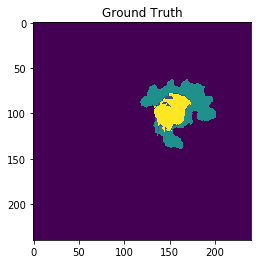

Iteration 60 of 193, loss = 0.8768


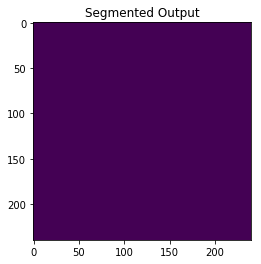

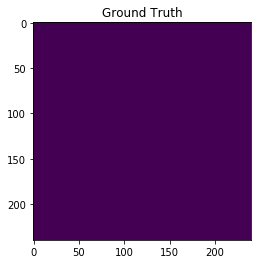

Iteration 90 of 193, loss = 0.8633


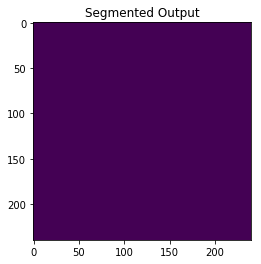

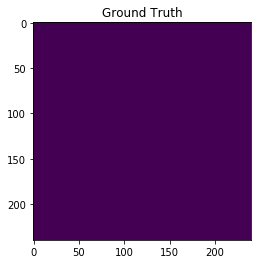

Iteration 120 of 193, loss = 0.8679


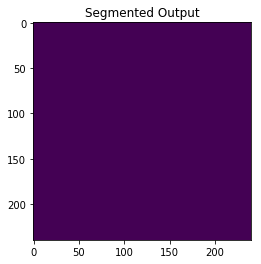

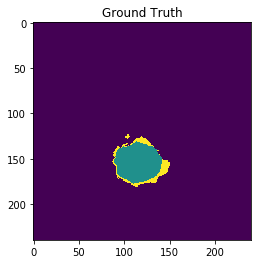

Iteration 150 of 193, loss = 0.8667


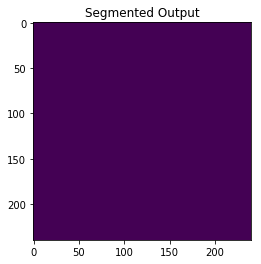

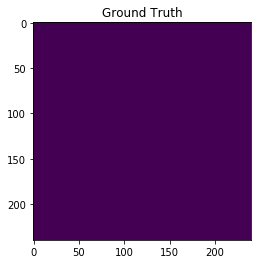

Iteration 180 of 193, loss = 0.8493


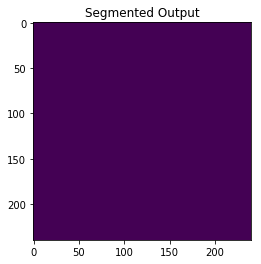

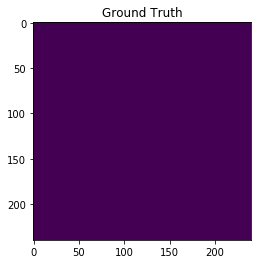

Iteration 0 of 193, loss = 0.8618


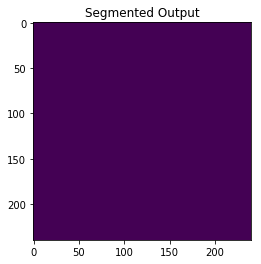

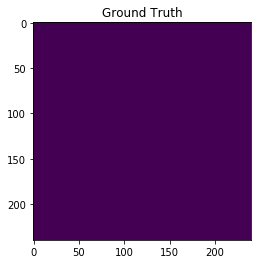

Iteration 30 of 193, loss = 0.8121


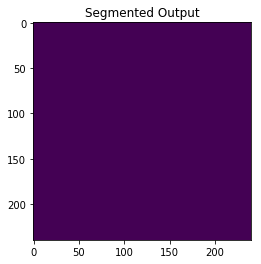

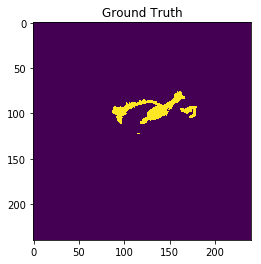

Iteration 60 of 193, loss = 0.7731


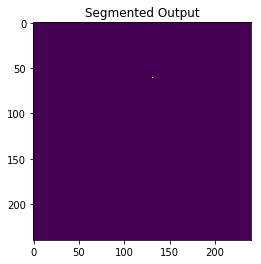

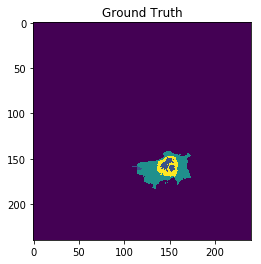

Iteration 90 of 193, loss = 0.7834


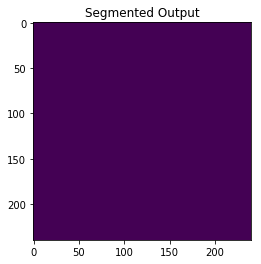

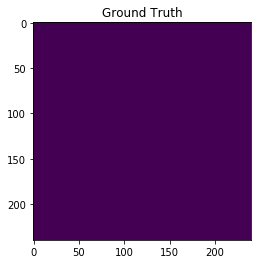

Iteration 120 of 193, loss = 0.7321


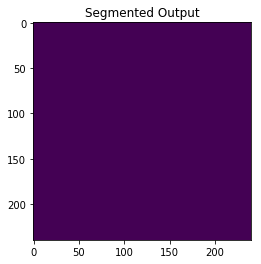

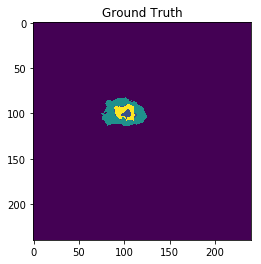

Iteration 150 of 193, loss = 0.7517


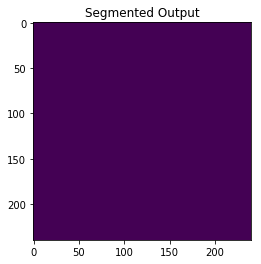

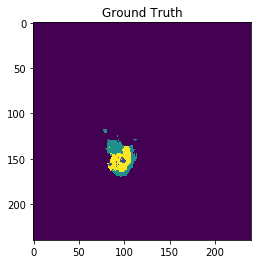

Iteration 180 of 193, loss = 0.7283


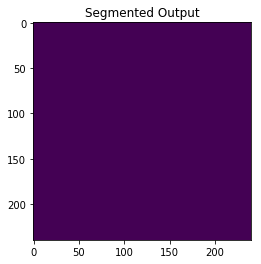

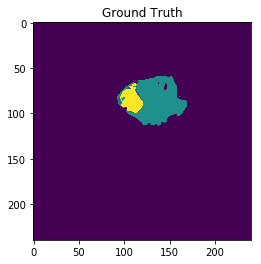

Iteration 0 of 193, loss = 0.7593


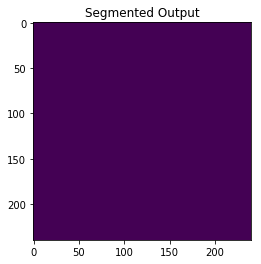

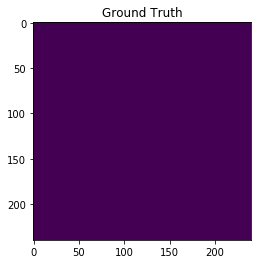

Iteration 30 of 193, loss = 0.7452


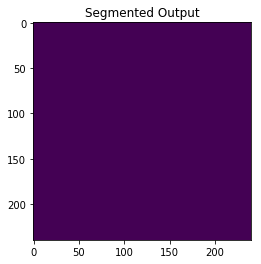

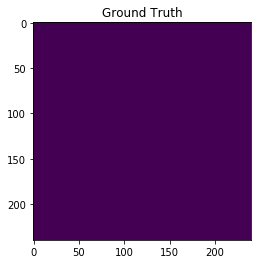

Iteration 60 of 193, loss = 0.7509


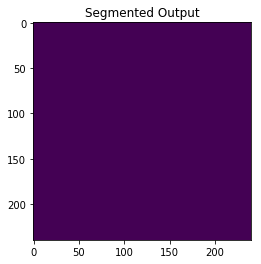

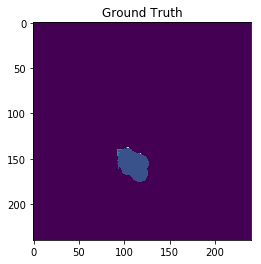

Iteration 90 of 193, loss = 0.7202


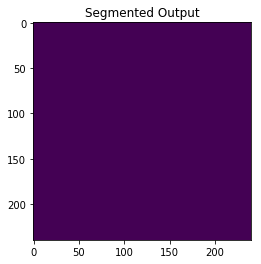

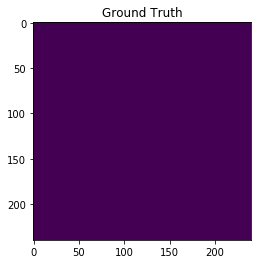

Iteration 120 of 193, loss = 0.7300


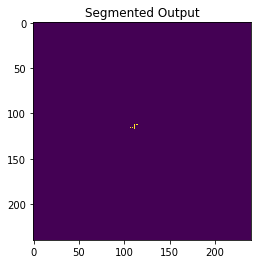

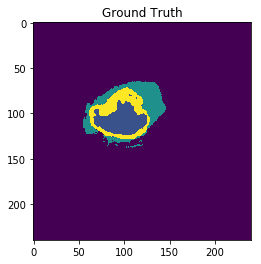

Iteration 150 of 193, loss = 0.7638


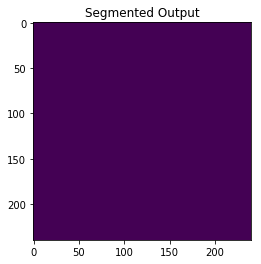

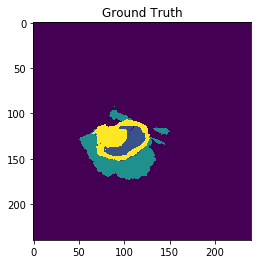

Iteration 180 of 193, loss = 0.7253


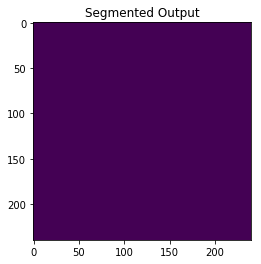

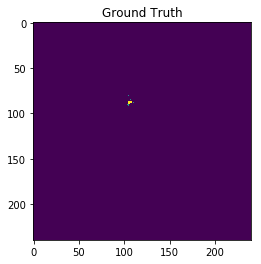

Iteration 0 of 193, loss = 0.7272


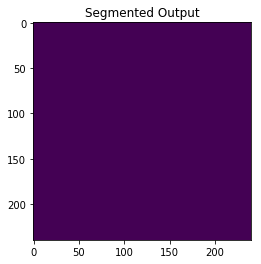

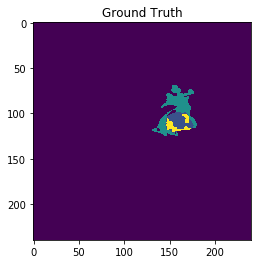

Iteration 30 of 193, loss = 0.7596


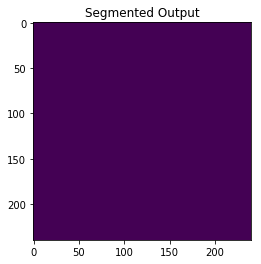

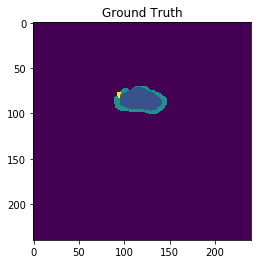

Iteration 60 of 193, loss = 0.7314


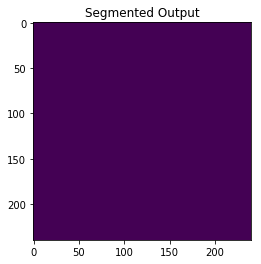

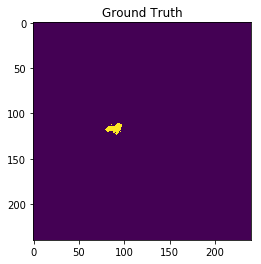

Iteration 90 of 193, loss = 0.7240


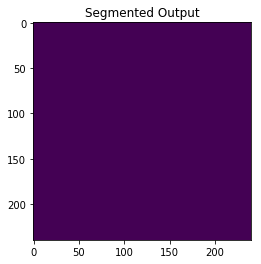

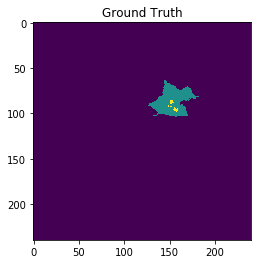

Iteration 120 of 193, loss = 0.7072


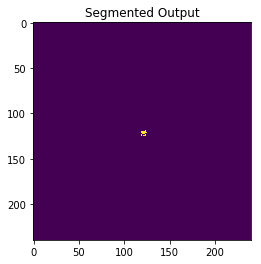

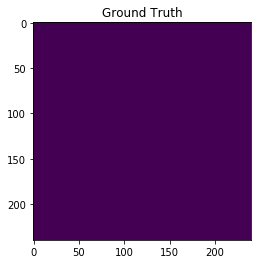

Iteration 150 of 193, loss = 0.7073


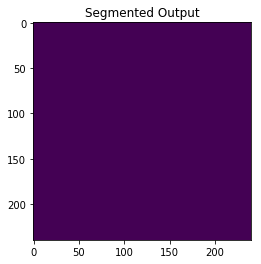

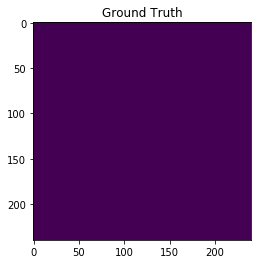

Iteration 180 of 193, loss = 0.7404


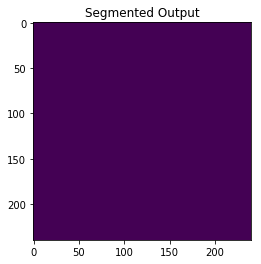

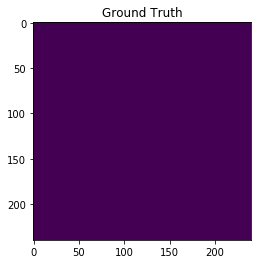

Iteration 0 of 193, loss = 0.7352


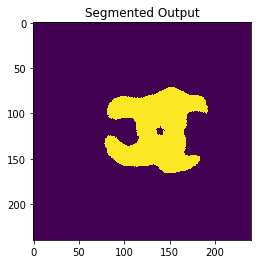

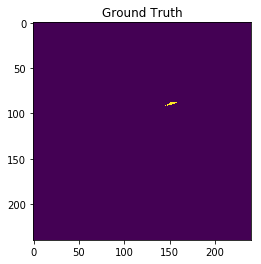

Iteration 30 of 193, loss = 0.6937


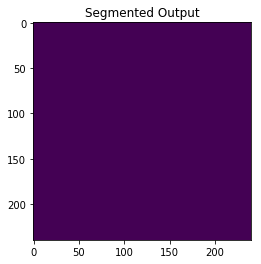

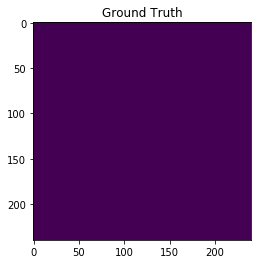

Iteration 60 of 193, loss = 0.7225


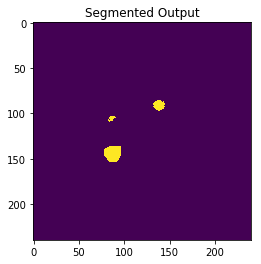

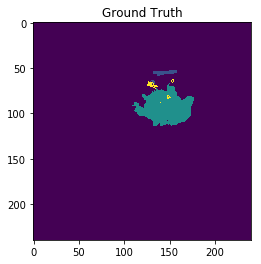

Iteration 90 of 193, loss = 0.6776


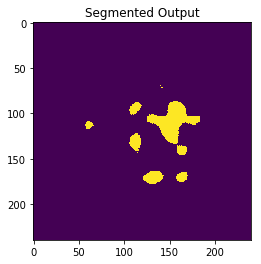

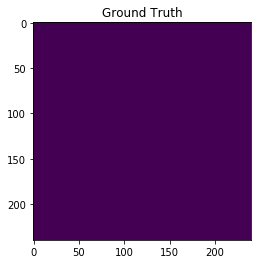

Iteration 120 of 193, loss = 0.6645


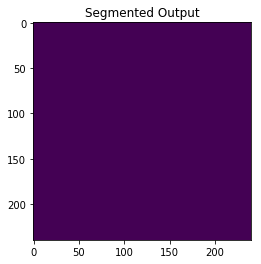

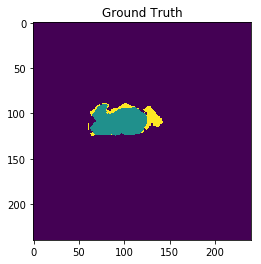

Iteration 150 of 193, loss = 0.7112


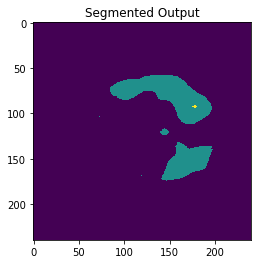

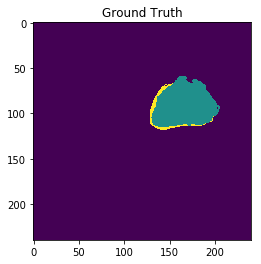

Iteration 180 of 193, loss = 0.6479


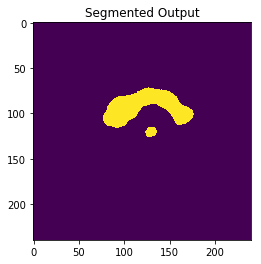

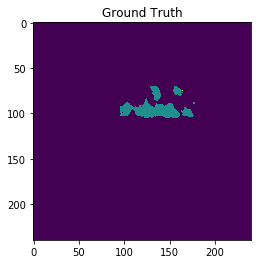

Iteration 0 of 193, loss = 0.6603


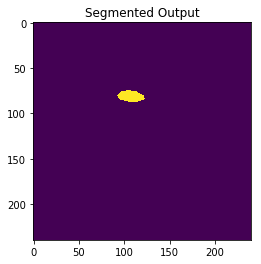

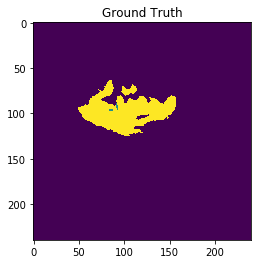

Iteration 30 of 193, loss = 0.6588


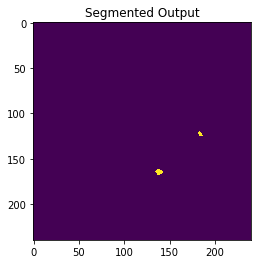

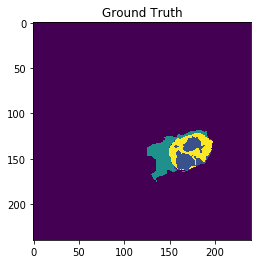

Iteration 60 of 193, loss = 0.6350


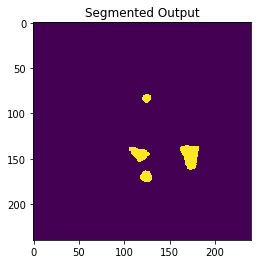

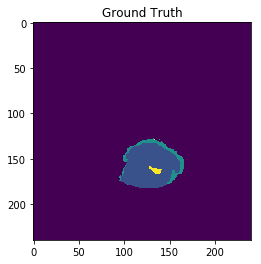

Iteration 90 of 193, loss = 0.6529


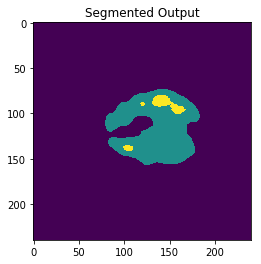

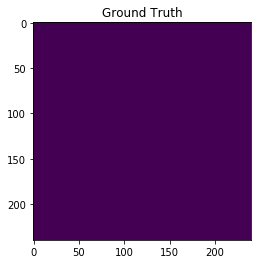

Iteration 120 of 193, loss = 0.6428


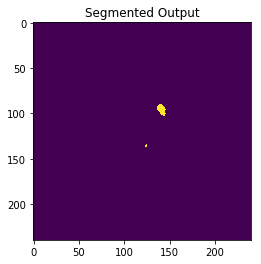

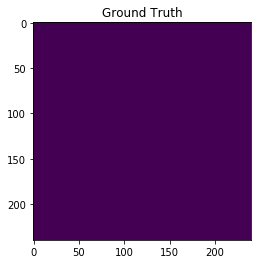

Iteration 150 of 193, loss = 0.6104


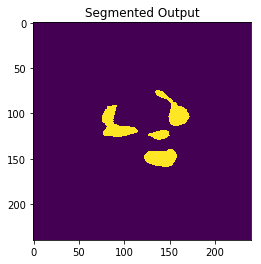

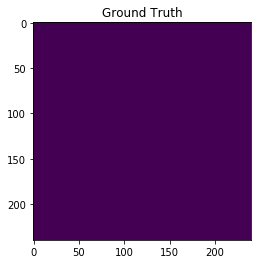

Iteration 180 of 193, loss = 0.5921


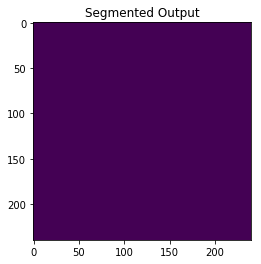

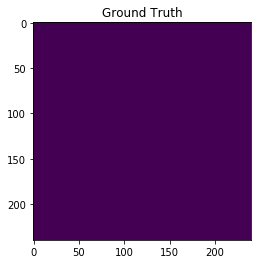

Iteration 0 of 193, loss = 0.5296


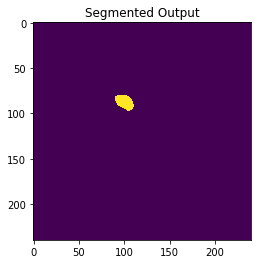

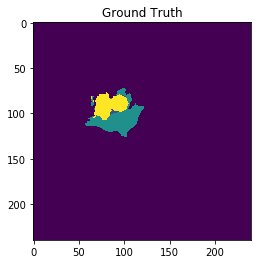

Iteration 30 of 193, loss = 0.6228


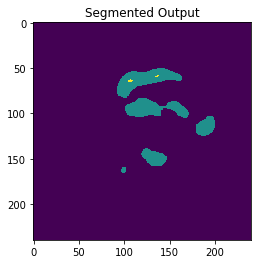

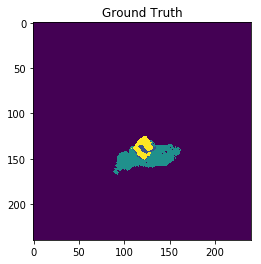

Iteration 60 of 193, loss = 0.6387


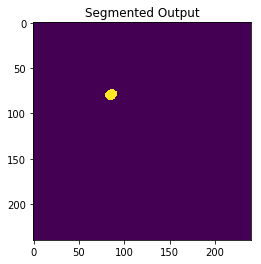

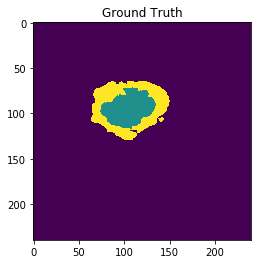

Iteration 90 of 193, loss = 0.5750


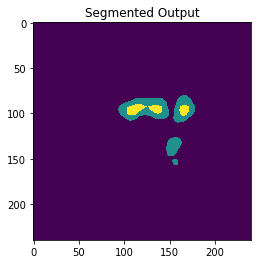

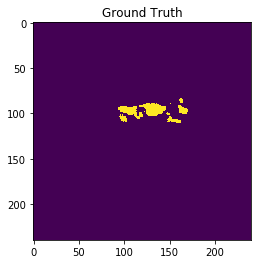

Iteration 120 of 193, loss = 0.5853


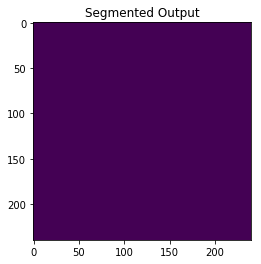

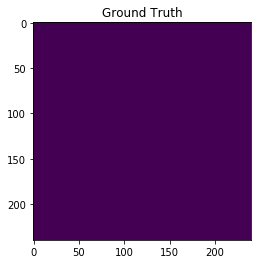

Iteration 150 of 193, loss = 0.5968


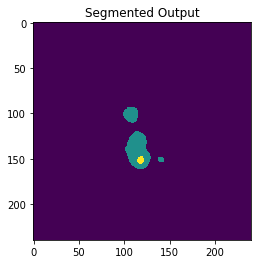

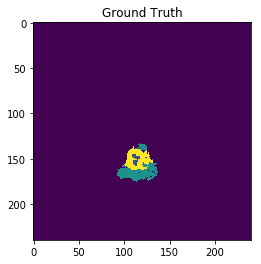

Iteration 180 of 193, loss = 0.5956


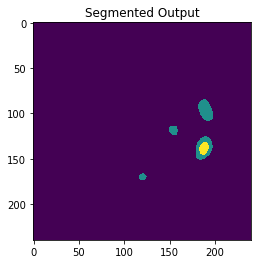

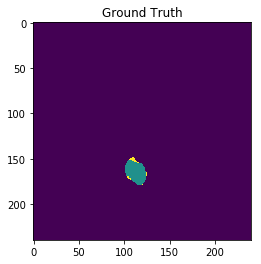

Iteration 0 of 193, loss = 0.5357


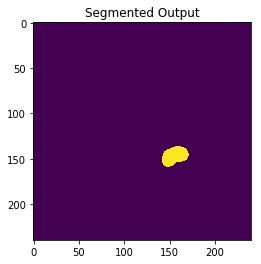

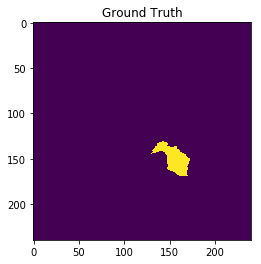

Iteration 30 of 193, loss = 0.6339


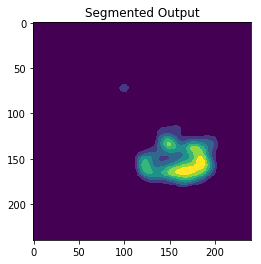

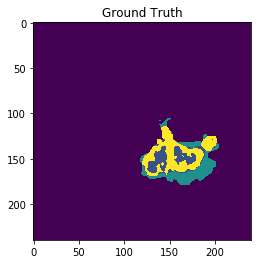

Iteration 60 of 193, loss = 0.5805


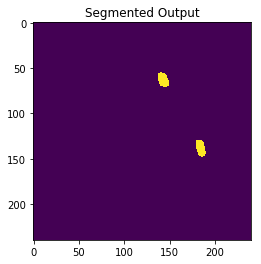

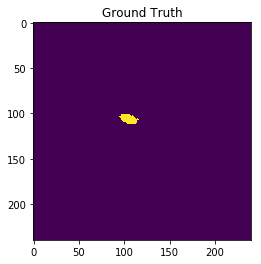

Iteration 90 of 193, loss = 0.5330


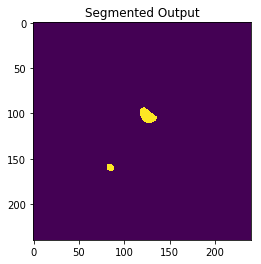

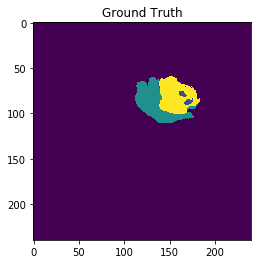

Iteration 120 of 193, loss = 0.5448


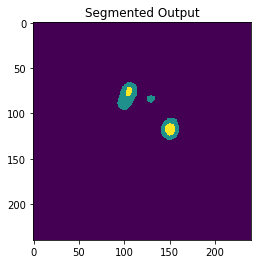

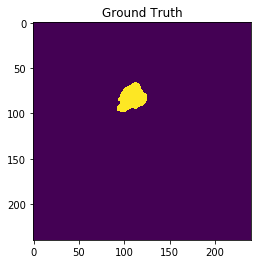

Iteration 150 of 193, loss = 0.5817


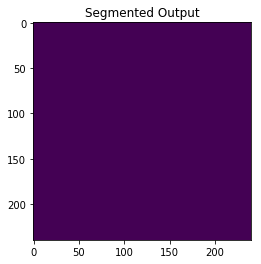

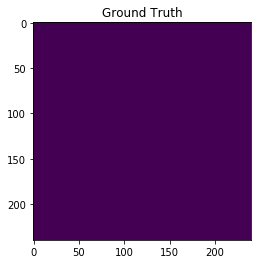

Iteration 180 of 193, loss = 0.6044


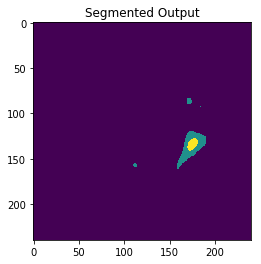

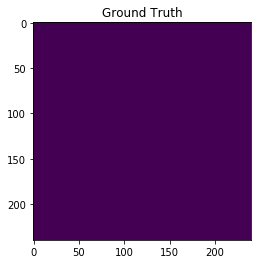

In [13]:
train_model(model, optimizer, epochs=10)

In [ ]:
plt.title('Loss over time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(range(len(loss_arr)), loss_arr)
,
#plt.figure()
#plt.plot(range(len(acc_arr)), acc_arr)

In [ ]:
check_accuracy(test_loader, model)

In [ ]:
print(len(inputs))

In [ ]:
25